In [1]:
#dependencies
import kaggle
import pandas as pd
import plotly.express as px
from sklearn import linear_model
from src.statsRpt import gen_reg_rpt, gen_cm_cr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgbm
import zipfile
import pydotplus
# import graphviz
from IPython.display import Image
pd.options.plotting.backend = "plotly"
pd.set_option('future.no_silent_downcasting', True)

#  Import Data and Review Features

In [2]:
!kaggle datasets download -d damlasogut/telco-churn-prediction

with zipfile.ZipFile('telco-churn-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('Resources')


Dataset URL: https://www.kaggle.com/datasets/damlasogut/telco-churn-prediction
License(s): other
telco-churn-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
Telco_churn_df = pd.read_csv('Resources/Telco-Customer-Churn.csv')

In [4]:

Telco_churn_df.set_index('customerID', inplace = True, drop = True)
Telco_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

## Review Continous Data

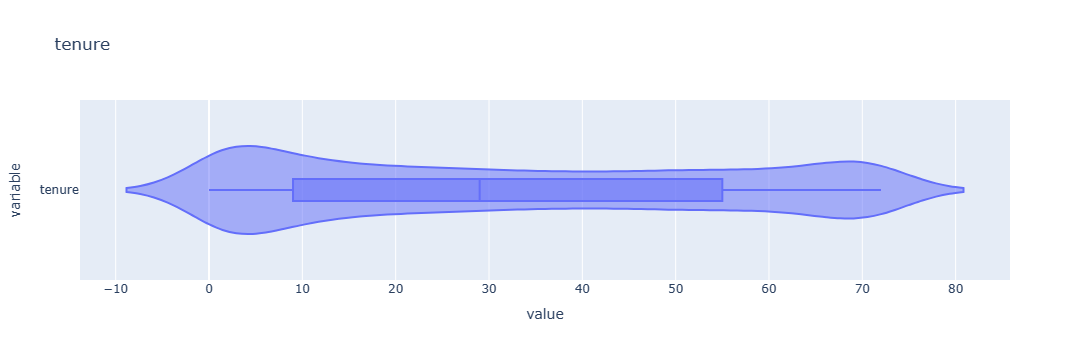

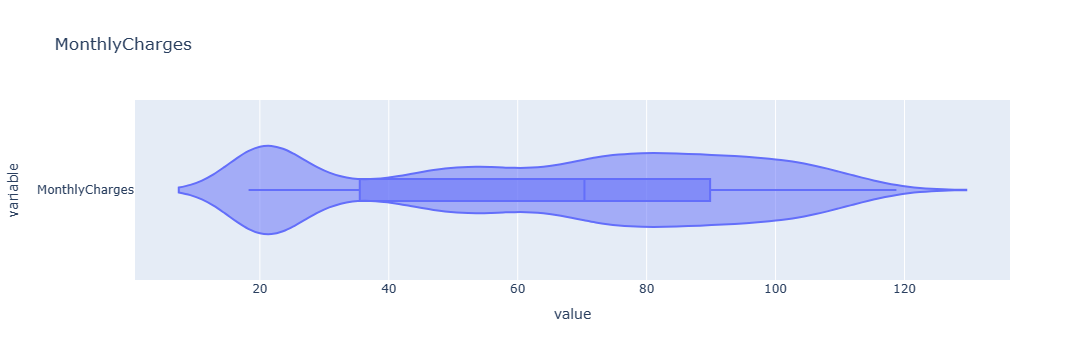

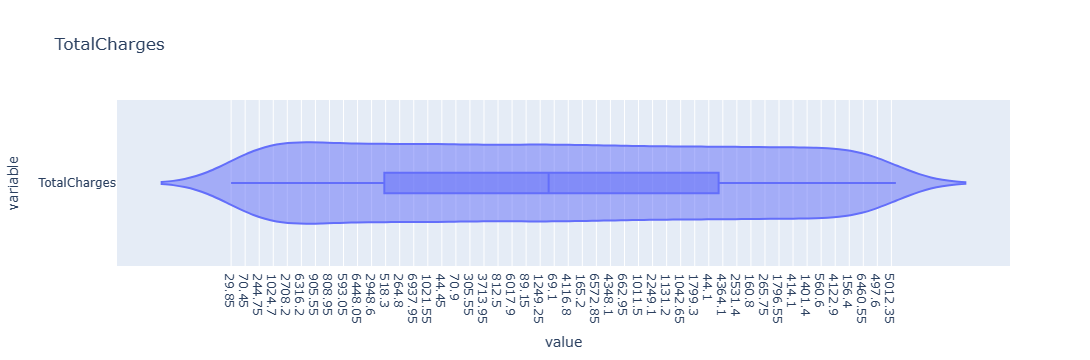

In [5]:
for feature in Telco_churn_df.columns:
    if feature in(['MonthlyCharges', 'TotalCharges', 'tenure']):
        fig = px.violin(Telco_churn_df[feature], box=True, orientation = 'h', title = feature, )
        fig.show()
        

## Review Categorical Features

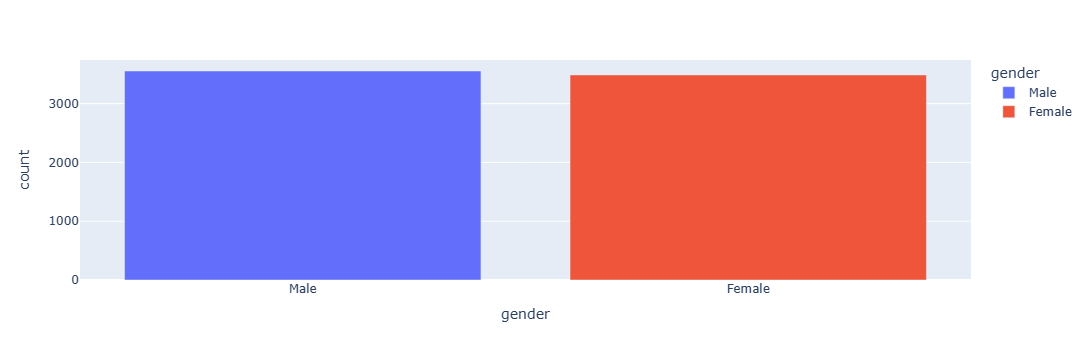

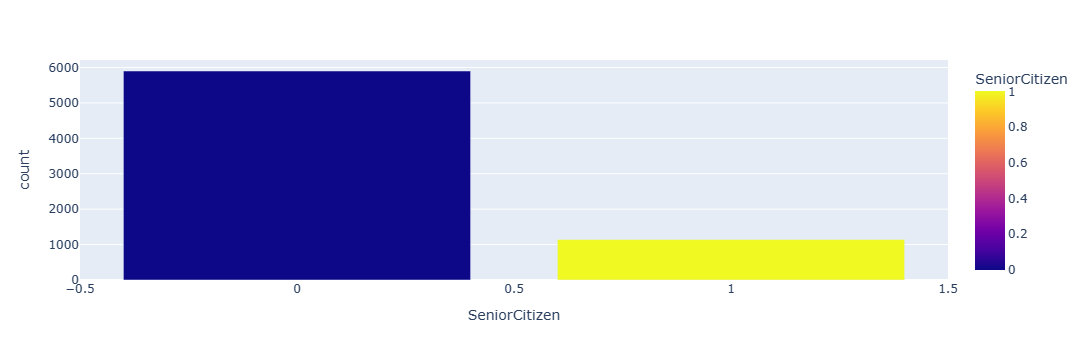

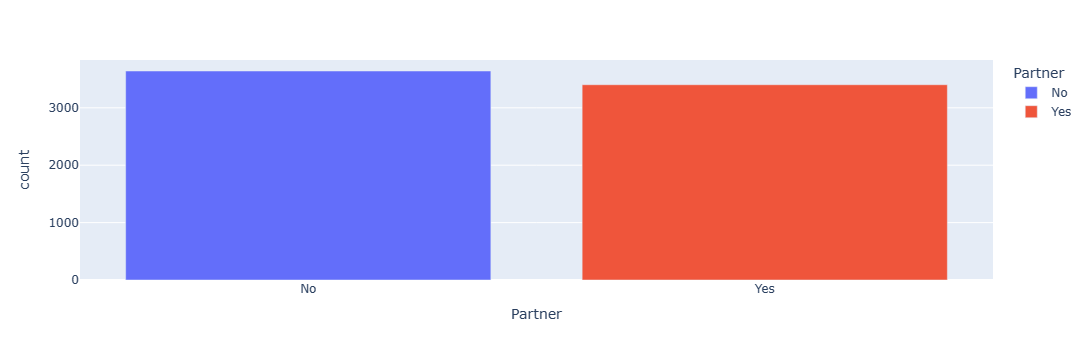

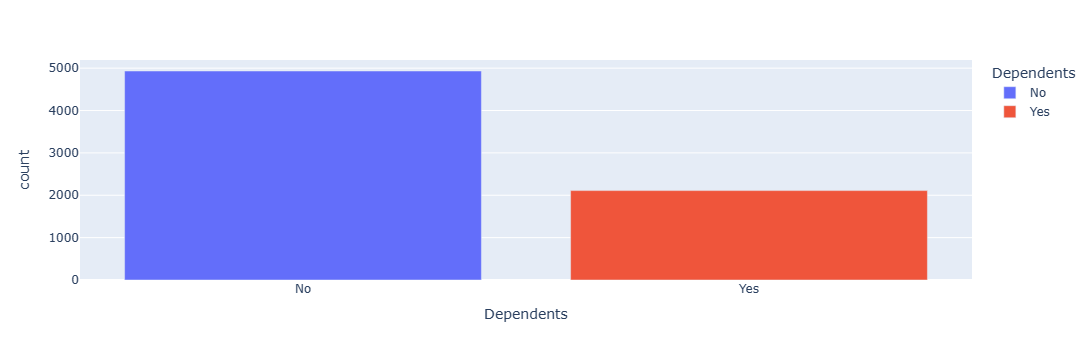

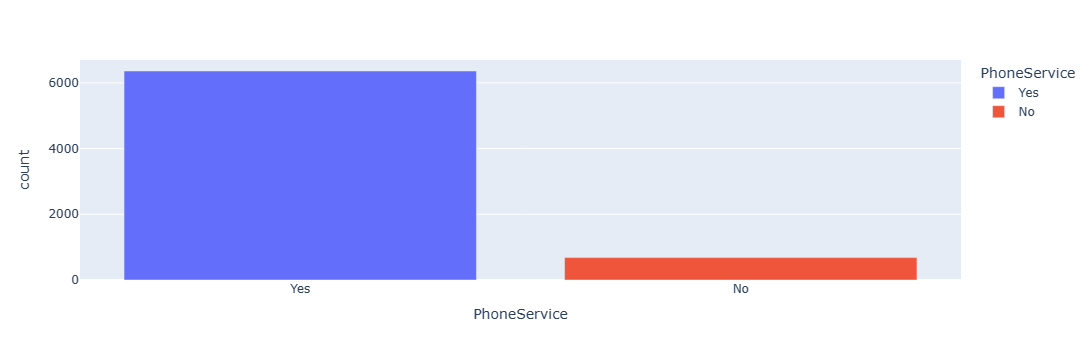

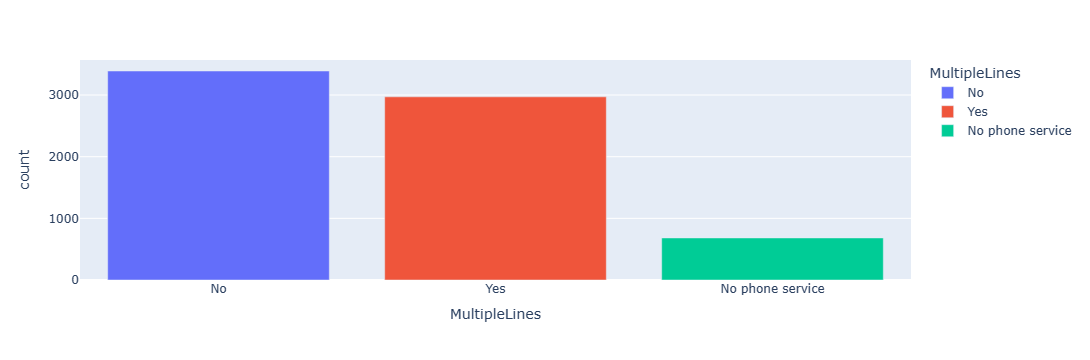

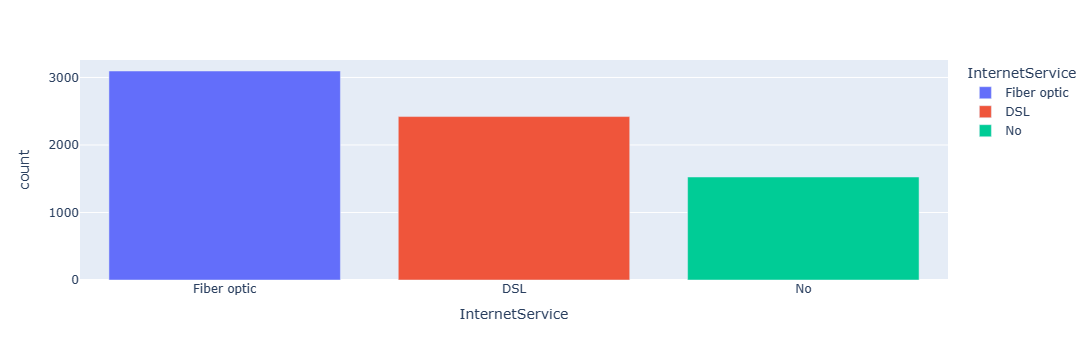

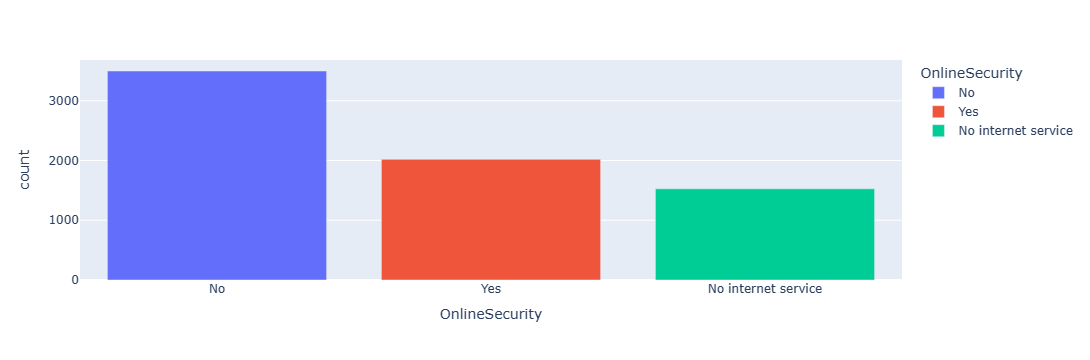

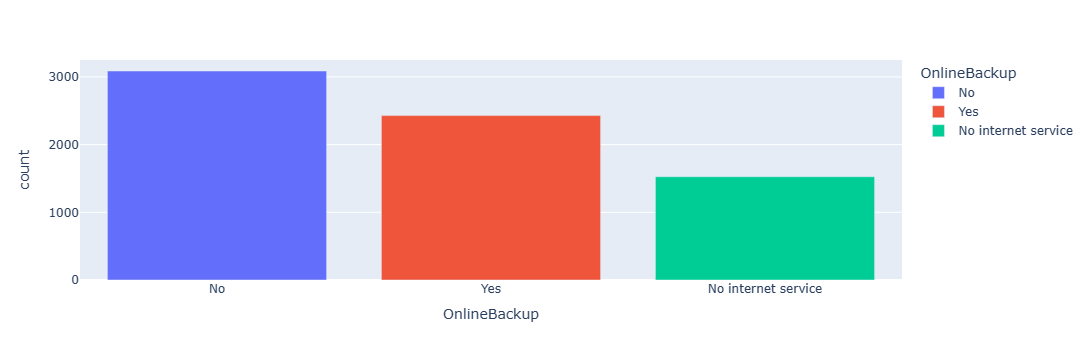

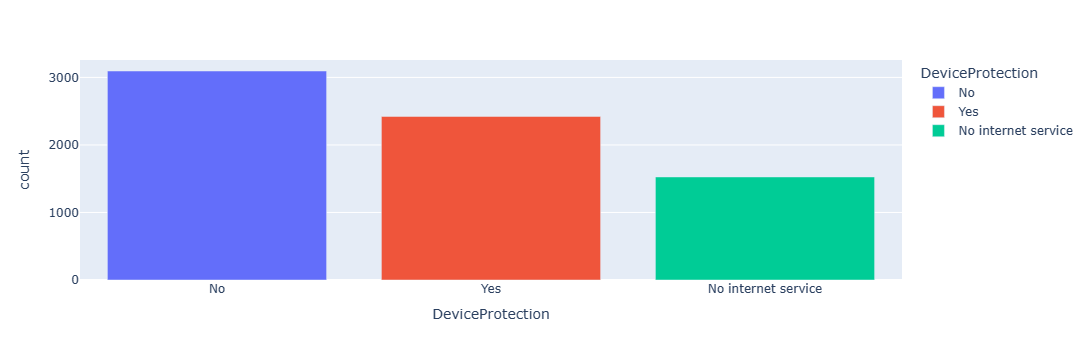

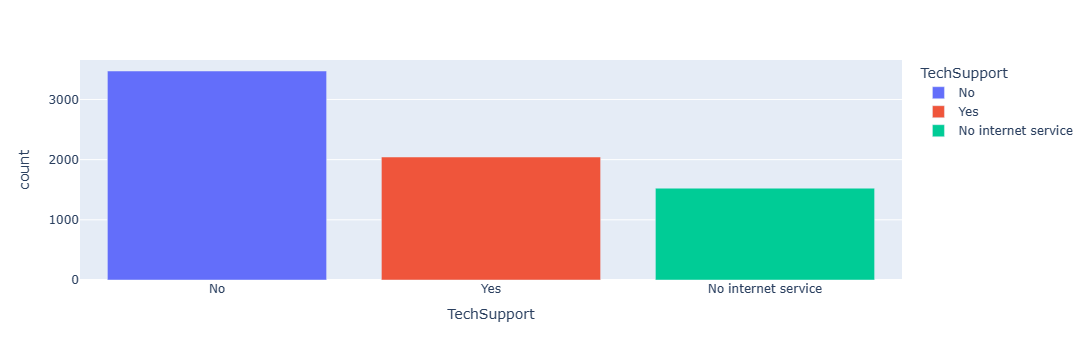

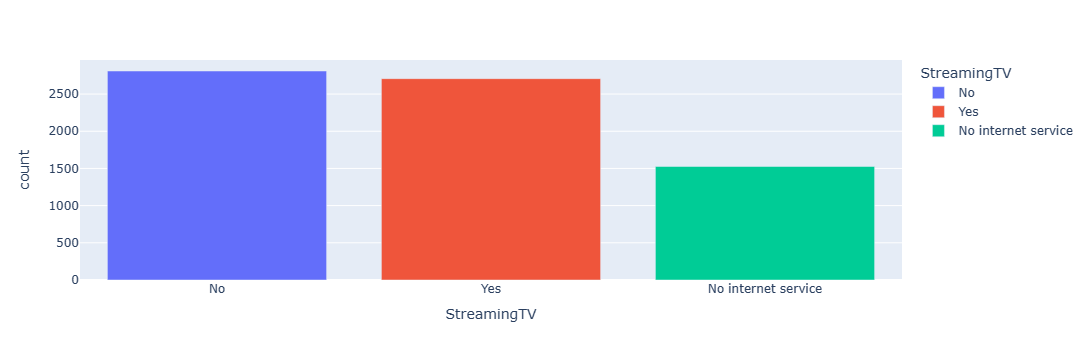

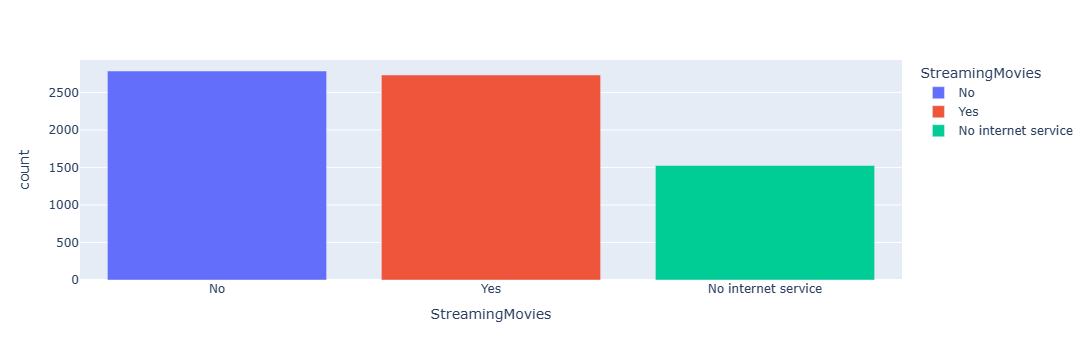

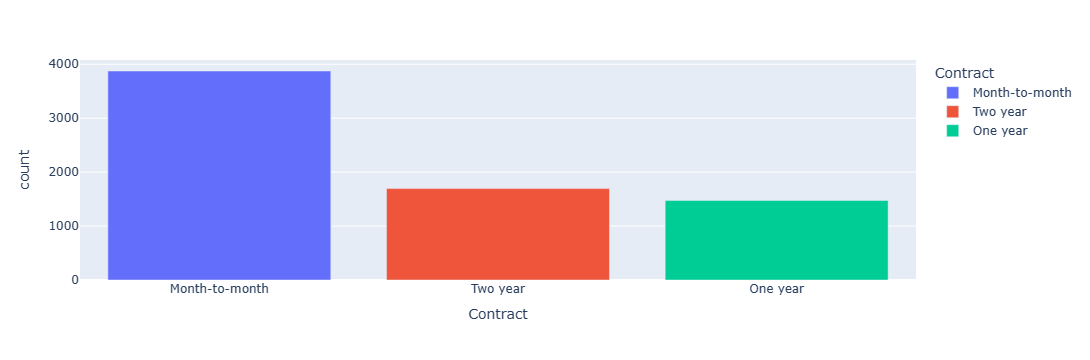

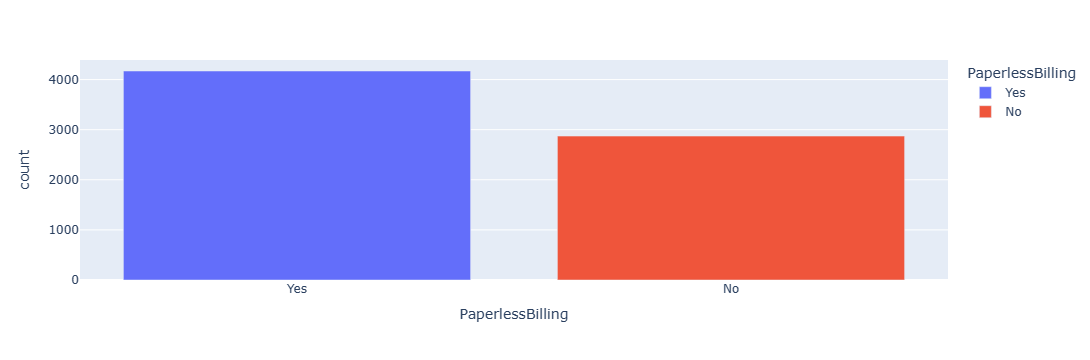

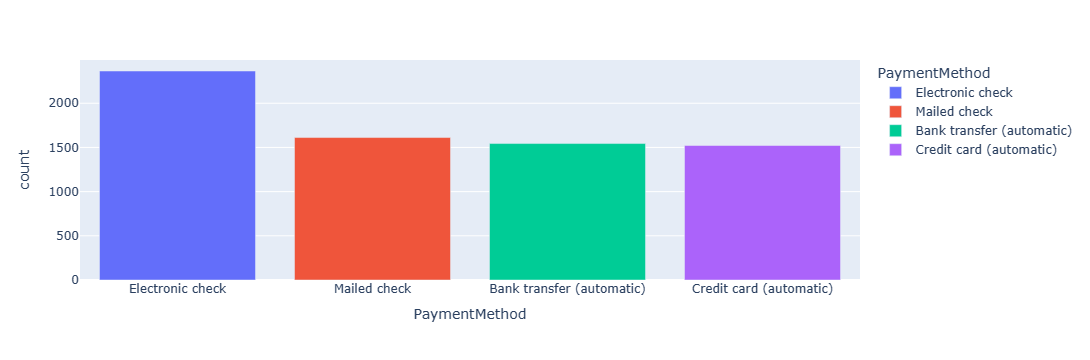

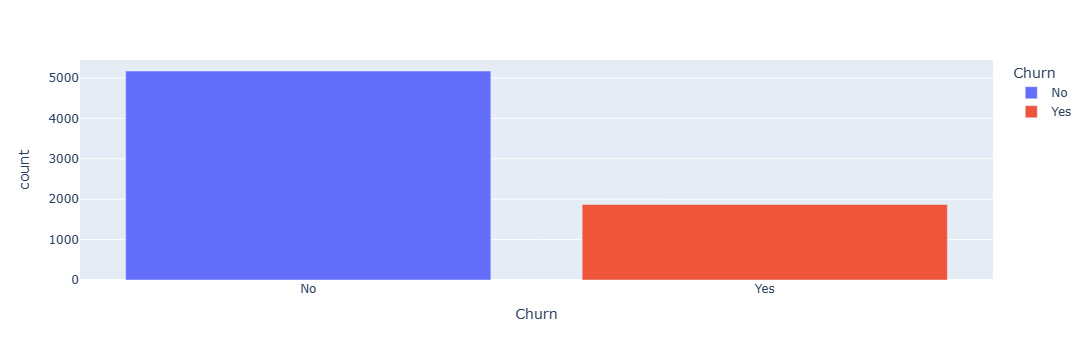

In [6]:
for feature in Telco_churn_df.columns:
    if feature not in(['MonthlyCharges', 'TotalCharges', 'tenure']):
        this=Telco_churn_df.value_counts(feature)
        this_df=pd.DataFrame(this)
        this_df.reset_index(inplace=True)
        fig = this_df.plot(kind='bar', x=feature, y='count', color=feature)
        fig.show()
        



## Review the distribution of the Target Feature 'Churn'

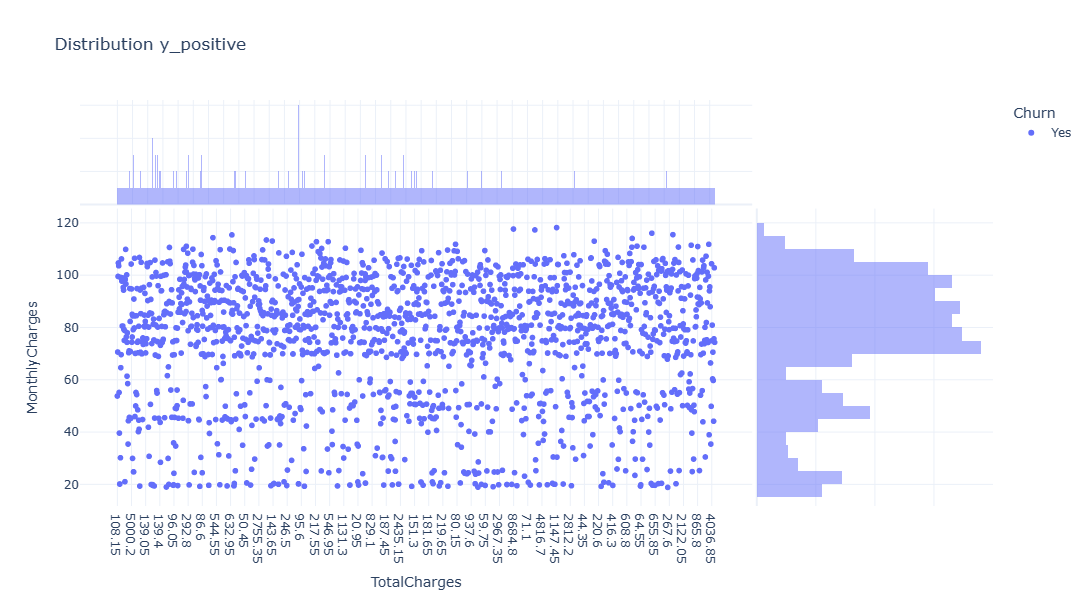

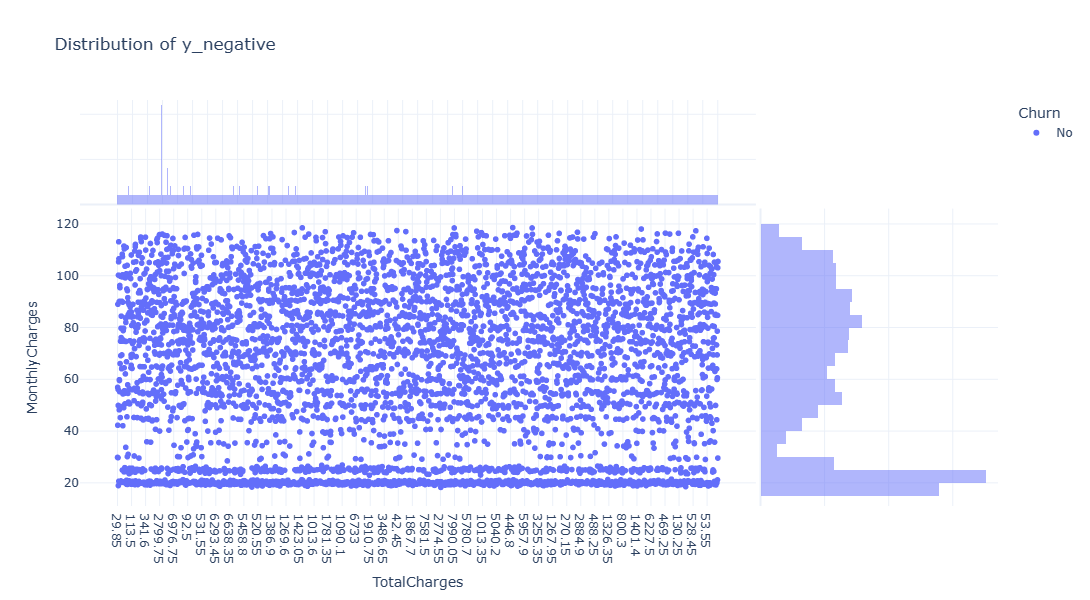

In [7]:
#Reviewing the distribution of y_postitive and y_negative lables.

fig3 = px.scatter(Telco_churn_df.loc[Telco_churn_df['Churn'] == 'Yes'], 
           x='TotalCharges', 
           y='MonthlyCharges', 
           color='Churn', 
           marginal_y = 'histogram', 
           marginal_x = 'histogram',
           title = 'Distribution y_positive',
           template='plotly_white',
           width=800, height=600)
fig3.update_layout(coloraxis_showscale=False)

fig3.show()

fig4=px.scatter(Telco_churn_df.loc[Telco_churn_df['Churn'] == 'No'], 
           x='TotalCharges', 
           y='MonthlyCharges', 
           color='Churn', 
           marginal_y = 'histogram', 
           marginal_x = 'histogram', 
           title = 'Distribution of y_negative',
           template='plotly_white',
           width=800, height=600)
fig4.update_layout(coloraxis_showscale=False)

fig4.show()

## Preprocessing 

### Encoding Categorical Features

In [8]:
#using get_dummies to encode categorical data.
X = Telco_churn_df.copy()
dummies=pd.get_dummies(X[['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']])

In [9]:
dummy_columns = dummies.columns.tolist()
X[dummy_columns] = dummies[dummy_columns]

In [10]:
X.drop(['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'], axis=1, inplace=True)

In [11]:
#converting TotalCharges to float from object, binary encoding the Churn target variable.
X['TotalCharges']=X['TotalCharges'].replace(' ', 0)
X['TotalCharges']=X['TotalCharges'].astype(float)
# X['Churn'] = X['Churn'].replace({'Yes': True, 'No': False})


In [12]:
## creating breaking out the y-set
y=X['Churn']
X.drop('Churn', axis = 1, inplace = True)
y

customerID
7590-VHVEG     No
5575-GNVDE     No
3668-QPYBK    Yes
7795-CFOCW     No
9237-HQITU    Yes
             ... 
6840-RESVB     No
2234-XADUH     No
4801-JZAZL     No
8361-LTMKD    Yes
3186-AJIEK     No
Name: Churn, Length: 7043, dtype: object

In [13]:
# creating the training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
myScaler = StandardScaler()
X_train_scaled = myScaler.fit_transform(X_train)
X_test_scaled = myScaler.transform(X_test)

## Evaluate the distribution of the the target across datasets

In [15]:
print('Distribution of y in the dataset')
print(y.value_counts()/y.count())
print('Distribution of y in the training set')
print(y_train.value_counts()/y_train.count())
print('Distribution of y in the testing set')
print(y_test.value_counts()/y_test.count())

Distribution of y in the dataset
Churn
No     0.73463
Yes    0.26537
Name: count, dtype: float64
Distribution of y in the training set
Churn
No     0.728323
Yes    0.271677
Name: count, dtype: float64
Distribution of y in the testing set
Churn
No     0.753549
Yes    0.246451
Name: count, dtype: float64


## Initial Model Evaluation

### Logistic Regression

In [16]:
model = linear_model.LogisticRegression(random_state = 1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
# gen_reg_rpt('Logistic Regression', y_test, y_pred)
gen_cm_cr('Logistic Regression', y_test, y_pred)

Confusion Matrix: Logistic Regression


Predicted Loyal 0  Predicted Churn 1
Loyal 0               1184                143
Churn 1                188                246

Accuracy Score : 0.812
Balanced Accuracy Score: 0.7295
Classification Report
              precision    recall  f1-score   support

          No       0.86      0.89      0.88      1327
         Yes       0.63      0.57      0.60       434

    accuracy                           0.81      1761
   macro avg       0.75      0.73      0.74      1761
weighted avg       0.81      0.81      0.81      1761



### Lightgbm

In [27]:
model = lgbm.LGBMClassifier(random_state = 1,scale_pos_weight = 2.68)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
# gen_reg_rpt('Logistic Regression', y_test, y_pred)
gen_cm_cr('LightGBM Classifier', y_test, y_pred)

[LightGBM] [Info] Number of positive: 1435, number of negative: 3847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271677 -> initscore=-0.986129
[LightGBM] [Info] Start training from score -0.986129
Confusion Matrix: LightGBM Classifier


Predicted Loyal 0  Predicted Churn 1
Loyal 0               1018                309
Churn 1                 96                338

Accuracy Score : 0.77
Balanced Accuracy Score: 0.773
Classification Report
              precision    recall  f1-score   support

          No       0.91      0.77      0.83      1327
         Yes       0.52      0.78      0.63       434

    accuracy                           0.77      1761
   macro avg       0.72      0.77      0.73      1761
weighted avg       0.82      0.77      0.78      1761



In [28]:
# lgbmimportances = model.feature_importances_
# # We can sort the features by their importance
# sorted(zip(model.feature_importances_, X.columns), reverse=True)

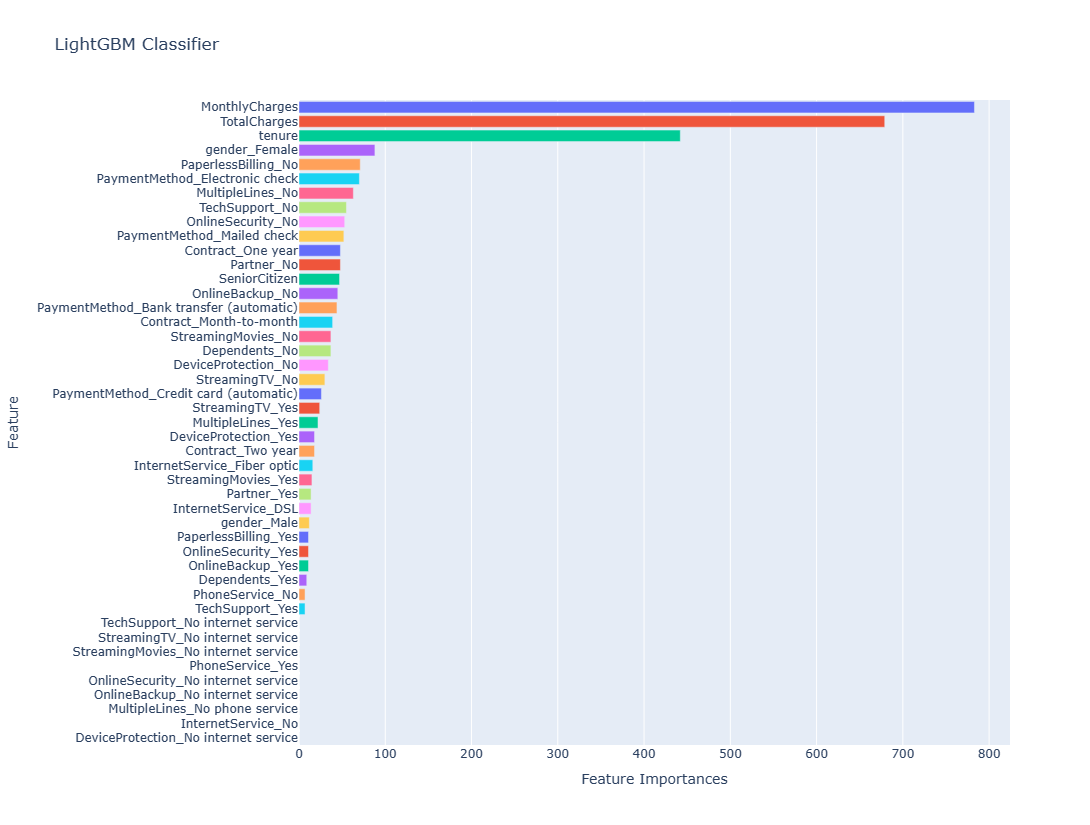

In [29]:
# Visualize the features by importance
lgbmimportances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
lgbmimportances_df.rename(columns={1:'Feature'}, inplace = True)
lgbmimportances_df.set_index(lgbmimportances_df['Feature'], inplace=True)
lgbmimportances_df.drop(columns='Feature', inplace=True)
lgbmimportances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
lgbmimportances_sorted = lgbmimportances_df.sort_values(by='Feature Importances', ascending=False)
fig = px.bar(lgbmimportances_sorted, 
             x='Feature Importances', 
             y=lgbmimportances_sorted.index, orientation='h', 
             title='LightGBM Classifier',
             color=lgbmimportances_sorted.index,
             width=1000, height=825)
fig.update_layout(showlegend=False)
fig.show()

### XGBoost Classifier

In [20]:
y_train_enc = y_train.replace({'Yes': 1, 'No': 0})
y_test_enc = y_test.replace({'Yes': True, 'No': 0})

In [21]:
y_test_enc = y_test_enc.tolist()

In [22]:
model = xgb.XGBClassifier(random_state = 1, scale_pos_weight = 2.68)
model.fit(X_train_scaled, y_train_enc)
y_pred_enc = model.predict(X_test_scaled)
# gen_reg_rpt('Logistic Regression', y_test, y_pred)
gen_cm_cr('XGBoost Classifier', y_test_enc, y_pred_enc)

Confusion Matrix: XGBoost Classifier


Predicted Loyal 0  Predicted Churn 1
Loyal 0               1048                279
Churn 1                136                298

Accuracy Score : 0.7643
Balanced Accuracy Score: 0.7382
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1327
           1       0.52      0.69      0.59       434

    accuracy                           0.76      1761
   macro avg       0.70      0.74      0.71      1761
weighted avg       0.79      0.76      0.77      1761



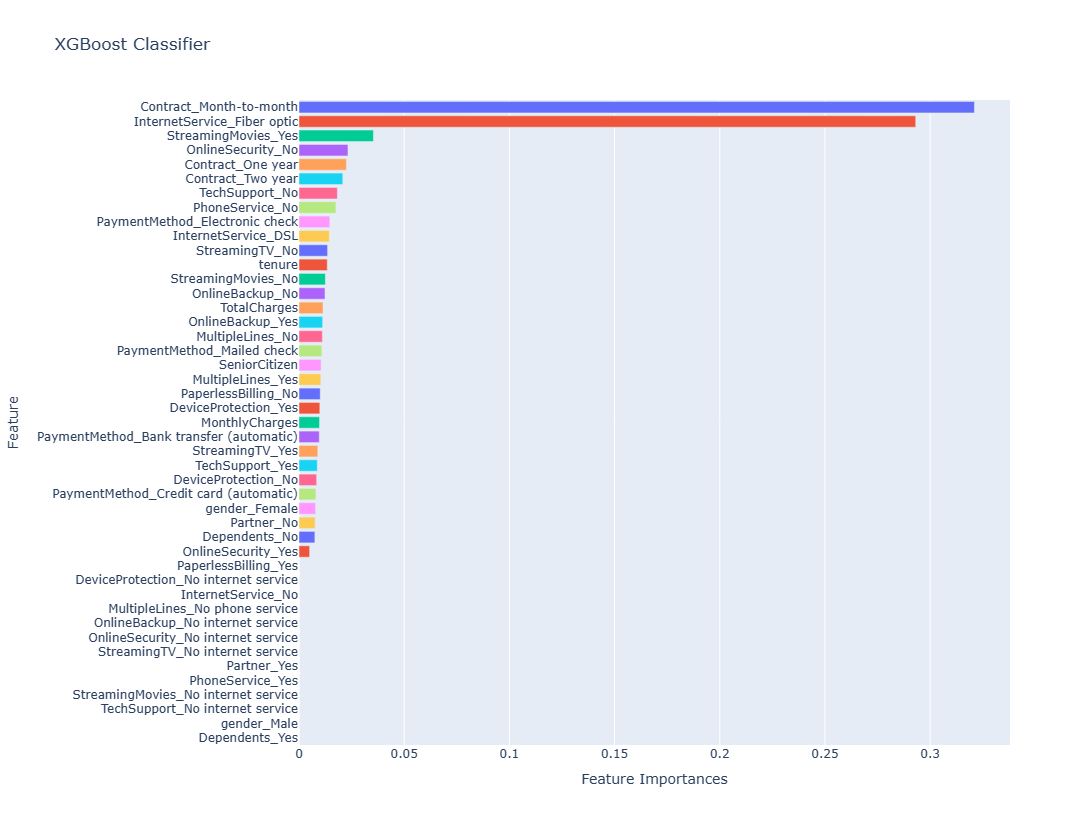

In [26]:
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.rename(columns={1:'Feature'}, inplace = True)
importances_df.set_index(importances_df['Feature'], inplace=True)
importances_df.drop(columns='Feature', inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=False)
fig = px.bar(importances_sorted, 
             x='Feature Importances', 
             y=importances_sorted.index, orientation='h', 
             title='XGBoost Classifier',
             color=importances_sorted.index,
             width=1000, height=825)
fig.update_layout(showlegend=False)
fig.show()

In [24]:
plot_col = X.columns
plot_col = plot_col.tolist()

In [64]:
dot_data = xgb.plot_tree(model, out_file=None, plot_col, class_names=['Predicted Loyal', 'Predicted Churn'], filled=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

SyntaxError: positional argument follows keyword argument (1609869447.py, line 1)

In [29]:
y_pred_df=pd.DataFrame(y_pred, columns=['Prediction'])
y_pred_df.value_counts()
y_train_enc_df=pd.DataFrame(y_train_enc, columns=['Training Actuals'])


In [ ]:
y_test

In [ ]:
y_actual=y_test.copy()
y_actual.rename('Actual', inplace=True)
y_actual

In [ ]:
y_prediction = pd.Series(y_pred, name='Prediction')
y_prediction

In [ ]:
prediction_df=pd.DataFrame(y_prediction)
actual_df=pd.DataFrame(y_actual)
actual_df.reset_index(inplace = True)
# actual_df
y_compare_df = pd.concat([actual_df, prediction_df], ignore_index=True, axis=1)
y_compare_df.rename(columns={0:'customerID', 1:'Actual', 2:'Predicted'}, inplace=True)
# y_compare_df.plot(kind='bar', x='customerID', y='Actual', color='customerID')

In [ ]:
y_compare_df